# DX 704 Week 3 Project

This week's project will give you practice with optimizing choices for bandit algorithms.
You will be given access to the bandit problem via a blackbox object, and you will investigate the bandit rewards to pick a suitable algorithm.

The full project description, a template notebook and supporting code are available on GitHub: [Project 3 Materials](https://github.com/bu-cds-dx704/dx704-project-03).


## Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Pick a Bandit Algorithm

Experiment with the multi-armed bandit interface using seed 0 to learn about the distribution of rewards and decide what kind of bandit algorithm will be appropriate.
A histogram will likely be helpful.

In [1]:
# DO NOT CHANGE

import numpy as np

class BanditProblem(object):
    def __init__(self, seed):
        self.seed = seed
        self.rng = np.random.default_rng(seed)

        self.num_arms = 3
        self.ns = self.rng.integers(low=1, high=10, size=self.num_arms)
        self.ps = self.rng.uniform(low=0.2, high=0.4, size=self.num_arms)

    def get_num_arms(self):
        return self.num_arms

    def get_reward(self, arm):
        if arm < 0 or arm >= self.num_arms:
            raise ValueError("Invalid arm")

        x = self.rng.uniform()
        x *= self.rng.binomial(self.ns[arm], self.ps[arm])

        return x


In [2]:
bandit0 = BanditProblem(0)

In [3]:
bandit0.get_num_arms()

3

In [26]:
bandit0.get_reward(arm=0)

2.4979324429601935

   arm  n (binomial trials)  p (binomial prob)      mean       std  min  \
0    0                    8           0.208195  0.827931  0.816700  0.0   
1    1                    6           0.203306  0.614205  0.675647  0.0   
2    2                    5           0.362654  0.898906  0.797448  0.0   

        max  P(reward=0)    Median     Pct95  
0  5.464203      0.15165  0.627327  2.547878  
1  5.581035      0.25470  0.450416  1.925525  
2  4.970628      0.10435  0.718393  2.511577  


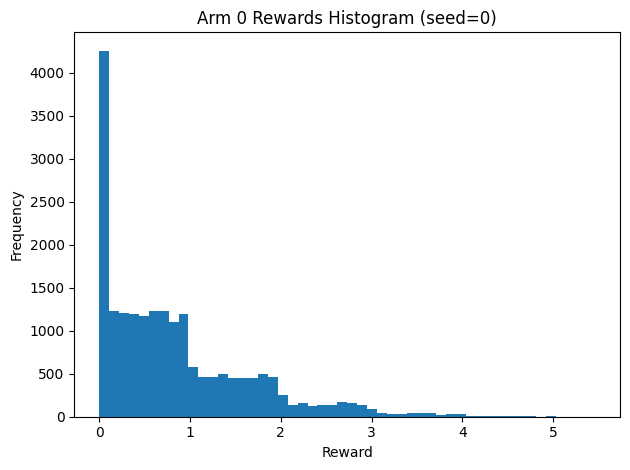

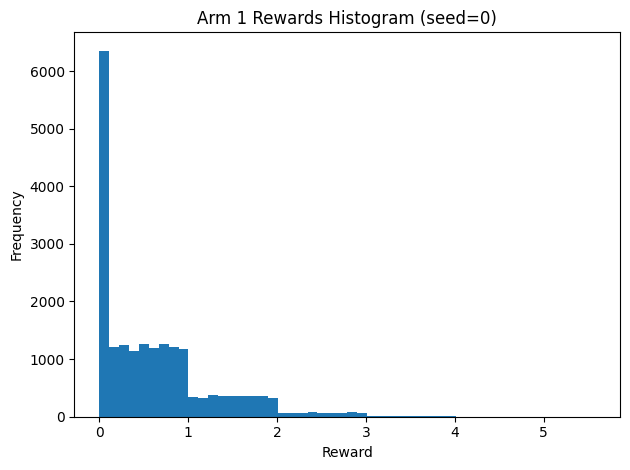

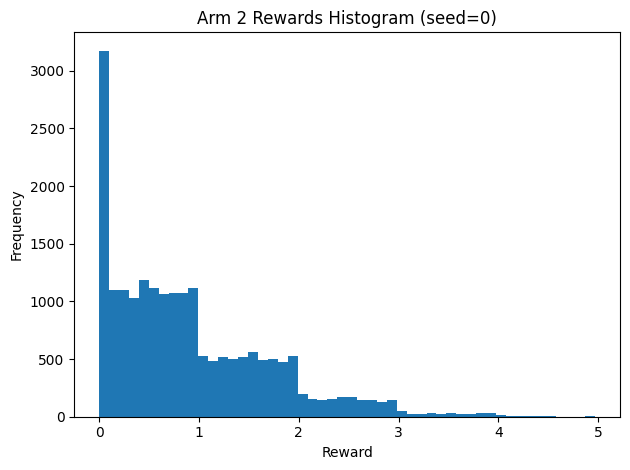

In [40]:
# YOUR CHANGES HERE

import matplotlib.pyplot as plt
import pandas as pd

ns = bandit0.ns
ps = bandit0.ps
num_arms = bandit0.get_num_arms()

# Sample rewards from each arm
SAMPLES = 20000
rewards = {arm: np.array([bandit0.get_reward(arm) for _ in range(SAMPLES)]) for arm in range(num_arms)}

# Compute summary statistics
def fraction_zero(x):
    return np.mean(x == 0.0)

summary_rows = []
for arm in range(num_arms):
    x = rewards[arm]
    row = {
        "arm": arm,
        "n (binomial trials)": int(ns[arm]),
        "p (binomial prob)": float(ps[arm]),
        "mean": float(np.mean(x)),
        "std": float(np.std(x, ddof=1)),
        "min": float(np.min(x)),
        "max": float(np.max(x)),
        "P(reward=0)": float(fraction_zero(x)),
        "Median": float(np.median(x)),
        "Pct95": float(np.percentile(x, 95)),
    }
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
print(summary_df)

for arm in range(num_arms):
    plt.figure()
    plt.hist(rewards[arm], bins=50)
    plt.title(f"Arm {arm} Rewards Histogram (seed=0)")
    plt.xlabel("Reward")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

Based on your investigation, pick an appropriate bandit algorithm to implement from the algorithms covered this week.
Write a file "algorithm-choice.txt" that states your choice and gives a few sentences justifying your choice and rejecting the alternatives.
Keep your explanation concise; overly verbose responses will be penalized.

## Part 2: Implement Bandit

Based on your decision, implement an appropriate bandit algorithm and pick 1000 actions using seed 2025002.

In [42]:
# YOUR CHANGES HERE

bandit = BanditProblem(2025002)
num_arms = bandit.get_num_arms()
steps = 1000

# UCB1 algorithm
counts = np.zeros(num_arms, dtype=int)
sums = np.zeros(num_arms, dtype=float)

history = []

for t in range(steps):
    if t < num_arms:
        action = t
    else:
        total_counts = np.sum(counts)
        avg_rewards = sums / counts
        confidence_bounds = np.sqrt(2 * np.log(total_counts) / counts)
        ucb_values = avg_rewards + confidence_bounds
        action = np.argmax(ucb_values)
    
    reward = bandit.get_reward(action)
    counts[action] += 1
    sums[action] += reward
    history.append({"action": action, "reward": reward})


Write a file "history.tsv" with columns action and reward in the order that the actions were taken.

In [43]:
# YOUR CHANGES HERE

history_df = pd.DataFrame(history)
history_df.to_csv("history.tsv", sep="\t", index=False)

Submit "history.tsv" in Gradescope.

## Part 3: Action Statistics

Based on the data from part 2, estimate the expected reward for each arm and write a file "actions.tsv" with the columns action, min_reward, mean_reward, max_reward.

In [44]:
# YOUR CHANGES HERE

history_df = pd.read_csv("history.tsv", sep="\t")

# Group by action and compute statistics
summary = history_df.groupby("action")["reward"].agg(
    min_reward="min", mean_reward="mean", max_reward="max"
).reset_index()

# Save to TSV
summary.to_csv("actions.tsv", sep="\t", index=False)

Submit "actions.tsv" in Gradescope.

## Part 4: Regret Estimates

Calculate the expected regret taking 1000 actions with the following strategies.

* uniform: Pick an arm uniformly at random.
* just-i: Always pick arm $i$. Do this for $i=0$ to $K-1$ where $K$ is the number of arms.
* actual: This should match your output in part 2.

In [50]:
# YOUR CHANGES HERE

history_df = pd.read_csv("history.tsv", sep="\t")
actions_df = pd.read_csv("actions.tsv", sep="\t")

steps = history_df.shape[0]
num_arms = actions_df.shape[0]

# Best mean reward among all arms 
best_mean_reward = actions_df["mean_reward"].max()

results = []

# Uniform random
uniform_mean = actions_df["mean_reward"].mean()
uniform_regret = steps * (best_mean_reward - uniform_mean)
results.append({"strategy": "uniform", "regret": uniform_regret})

# Just-i
for i in range(num_arms):
    mean_i = actions_df.loc[actions_df["action"] == i, "mean_reward"].iloc[0]
    regret_i = steps * (best_mean_reward - mean_i)
    results.append({"strategy": f"just-{i}", "regret": regret_i})

# Actual
actual_total_reward = history_df["reward"].sum()
actual_regret = steps * best_mean_reward - actual_total_reward
results.append({"strategy": "actual", "regret": actual_regret})

Write your results to a file "strategies.tsv" with the columns strategy and regret.

In [51]:
# YOUR CHANGES HERE

strategies_df = pd.DataFrame(results)
strategies_df.to_csv("strategies.tsv", sep="\t", index=False)

Submit "strategies.tsv" in Gradescope.

## Part 5: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgements are appropriate, just write none in the file.


Submit "acknowledgments.txt" in Gradescope.

## Part 6: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.

Submit "project.ipynb" in Gradescope.